# word2vec

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import word2vec
import config
from ast import literal_eval
import re
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', 100)

In [25]:
target = config.target_user
target_month = config.target_month
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
english_file

'/home/key/code/python/twitter_topics/data/twitter/tweets/trivadis/2016-11_english.csv'

In [9]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))

tweets_english['text_processed'] = tweets_english['text_processed'].apply(lambda x: list(map(lambda s: s.lower(),x)))
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))
X_train_en[:10]

0    alphahelixsmc it appears that apple is still considering a foldable iphone would you use it http...
1    alphahelixsmc it appears that apple is still considering a foldable iphone would you use it http...
2                             dsgersten learn more about vfiorg and csecoalition https://t.co/lehzvz0vzj
3    windows 10 deployment tools techniques and processes the must-know concepts for it professionals...
4    vcpkg updates static linking is now available one month ago we announced the availability of vcp...
5    iamcporg make sure to sign up for the webinar 3 superpowers of p2p the practice the profits and ...
6    justinslagle so many of my microsoft partners have been waiting for this microsoftteams has arri...
7    smbinsiderjoe us smb marketing events lead davidcu206 on the latest episode of offpremwithterry ...
8     jon_rivers microsoft launches teams to take on slack https://t.co/nvfxbtgxge teams microsoft iamcp
9    iamcptpa join the iamcp tampa chapter meeting on 1

#### Try both with and without stop word removal 

In [10]:
stopwords_nltk = set(stopwords.words("english"))
relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
#relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [11]:
sentences = []  
for tweet in X_train_en:
    words = tweet.split()
    sentences += [[word for word in words if word not in stopwords_filtered]]
    #sentences += [words]

In [12]:
len(sentences), len(sentences[0])

(2352, 10)

In [13]:
num_features = 100    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 2       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
window = context, sample = downsampling)

In [14]:
len(model.vocab)

6759

In [15]:
model.most_similar('oracle')

[('not', 0.8817278146743774),
 ('data', 0.8692392110824585),
 ('great', 0.8629403114318848),
 ('but', 0.861784815788269),
 ('new', 0.8604185581207275),
 ('business', 0.858803391456604),
 ('2016', 0.8575323820114136),
 ('sql', 0.8486918807029724),
 ('cloud', 0.8484049439430237),
 ('lukaseder', 0.8475677967071533)]

In [23]:
model.most_similar('machinelearning')

[('racsig', 0.3615770936012268),
 ('chant', 0.3573278784751892),
 ('https://t.co/5wpc1el7wv', 0.333243191242218),
 ('peak', 0.33149340748786926),
 ('board', 0.327642560005188),
 ('category5moron', 0.3139312267303467),
 ('yurikushch', 0.3136376142501831),
 ('azerbaijan', 0.313535213470459),
 ('https://t.co/43dg5p9are', 0.3053702712059021),
 ('baskinrobbins', 0.30496442317962646)]

In [24]:
[s for s in sentences if 'machinelearning' in s]

[['multinomial',
  'regression',
  'rstats',
  'https://t.co/zr6tptbkil',
  'machinelearning',
  'datascience'],
 ['zkajdan',
  'multinomial',
  'regression',
  'rstats',
  'https://t.co/zr6tptbkil',
  'machinelearning',
  'datascience'],
 ['machinelearning',
  'talend',
  '101',
  'intro',
  'decision',
  'trees',
  'https://t.co/dhnv6e6i06',
  'apachespark',
  'datascience',
  'https://t.co/gz0mmi2ewc'],
 ['talend',
  'machinelearning',
  'talend',
  '101',
  'intro',
  'decision',
  'trees',
  'https://t.co/dhnv6e6i06',
  'apachespark',
  'datascience',
  'https://t.co/…'],
 ['talend',
  'machinelearning',
  'talend',
  '101',
  'intro',
  'decision',
  'trees',
  'https://t.co/dhnv6e6i06',
  'apachespark',
  'datascience',
  'https://t.co/…'],
 ['talend',
  'machinelearning',
  'talend',
  '101',
  'intro',
  'decision',
  'trees',
  'https://t.co/dhnv6e6i06',
  'apachespark',
  'datascience',
  'https://t.co/…'],
 ['talend',
  'machinelearning',
  'talend',
  '101',
  'intro',
  '

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6759
[t-SNE] Computed conditional probabilities for sample 2000 / 6759
[t-SNE] Computed conditional probabilities for sample 3000 / 6759
[t-SNE] Computed conditional probabilities for sample 4000 / 6759
[t-SNE] Computed conditional probabilities for sample 5000 / 6759
[t-SNE] Computed conditional probabilities for sample 6000 / 6759
[t-SNE] Computed conditional probabilities for sample 6759 / 6759
[t-SNE] Mean sigma: 0.006968
[t-SNE] Iteration 25: error = 1.6562629, gradient norm = 0.0036590
[t-SNE] Iteration 50: error = 1.6530443, gradient norm = 0.0027777
[t-SNE] Iteration 75: error = 1.6399248, gradient norm = 0.0008617
[t-SNE] Iteration 75: gradient norm 0.000862. Finished.
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.639925
[t-SNE] Iteration 100: error = 1.6316743, gradient norm = 0.0006695
[t-SNE] Iteration 100: gra

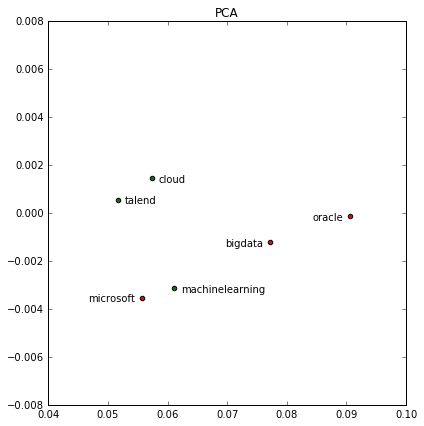

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
words = ['oracle', 'talend', 'microsoft', 'cloud', 'bigdata', 'machinelearning']
vectors = model.syn0

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vectors)


tsne = TSNE(n_components=2, random_state=0, verbose=10, init='pca')
tsne_2d = tsne.fit_transform(vectors)


first = True

#for name, transform in zip(['PCA', 'TSNE'], [pca_2d, tsne_2d]):  
for name, transform in zip(['PCA'], [pca_2d]):   
    plt.figure(figsize=(6,6))
    for point, word in zip(transform , words):
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "medium"
            )
        first = not first 
    plt.title(name)
    plt.tight_layout()
plt.show()